In [1]:
%load_ext autoreload
%autoreload 2

import os
from PIL import Image, ImageOps
import requests
import torch
import matplotlib.pyplot as plt
import numpy as np

import torch
import requests
from tqdm import tqdm
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline
import torchvision.transforms as T
from typing import Union, List, Optional, Callable

from utils import preprocess, prepare_mask_and_masked_image, recover_image, prepare_image
to_pil = T.ToPILImage()

/local/java/python-ml/22-12-21-python3.9/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (3.0.4)/charset_normalizer (2.1.1) doesn't match a supported version!
  warnings.warn(
2024-11-14 13:27:02.474026: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 13:27:03.427556: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /local/java/cuda-11.6.0/lib64/:/local/java/cudnn-linux-x86_64-8.5.0.96_cuda11-archive/lib/:/local/java/cuda-12.6.2/lib64/:/local/java/cudnn-linux-x86_64-9.5.1.17_cud

### First lets instantiate an inpainting stable diffusion model

In [2]:
# make sure you're logged in with `huggingface-cli login` - check https://github.com/huggingface/diffusers for more details

pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    variant="fp16",
    torch_dtype=torch.float16,
)
pipe_inpaint = pipe_inpaint.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### The image to immunize
Now let's load image + some mask so that we can inpaint the rest!

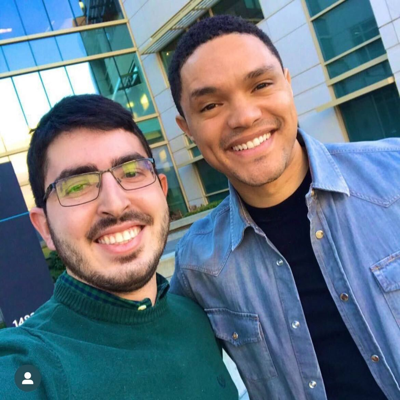

In [3]:
init_image = Image.open(f'../assets/trevor_5.jpg').convert('RGB').resize((400,400))
mask_image = Image.open(f'../assets/trevor_5.tif').convert('RGB')
mask_image = ImageOps.invert(mask_image).resize((400,400))

init_image

### Target image
Here, different from the img2img notebook, we will drive the above image towards the embedding of some random target image from the internet!

You can still effectively attack towards an embedding of zeros too! 

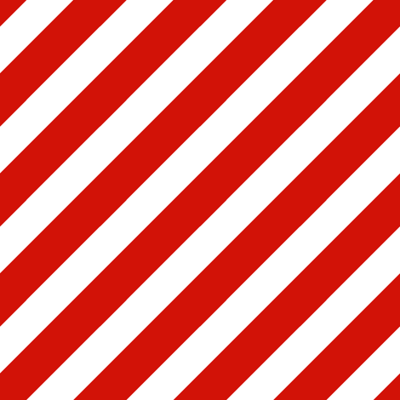

In [4]:
# target_url = "https://srv-2.eden-gallery.com/wp-content/uploads/sites/15/2018/04/eden-fine-art-yoel-benharrouche-l_etape-intermediaire_2.jpg"
# target_url = "https://previews.123rf.com/images/marsono/marsono1708/marsono170800715/85827714-logotipo-de-advertencia-tri%C3%A1ngulo-rojo.jpg"
target_url = "https://i.pinimg.com/originals/18/37/aa/1837aa6f2c357badf0f588916f3980bd.png"
response = requests.get(target_url)
target_image = Image.open(BytesIO(response.content)).convert("RGB")
target_image = target_image.resize((400, 400))
target_image

### Complex attack implementation
Below is the implementation of an end2end attack on the stable diffusion pipeline using PGD. This requires a GPU Memory >= 40Gbs (we ran on 1 A100)

In [5]:
# A differentiable version of the forward function of the inpainting stable diffusion model! See https://github.com/huggingface/diffusers
def attack_forward(
        self,
        prompt: Union[str, List[str]],
        masked_image: Union[torch.FloatTensor, Image.Image],
        mask: Union[torch.FloatTensor, Image.Image],
        height: int = 400,
        width: int = 400,
        num_inference_steps: int = 50,
        guidance_scale: float = 7.5,
        eta: float = 0.0,
    ):

        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        text_embeddings = self.text_encoder(text_input_ids.to(self.device))[0]

        uncond_tokens = [""]
        max_length = text_input_ids.shape[-1]
        uncond_input = self.tokenizer(
            uncond_tokens,
            padding="max_length",
            max_length=max_length,
            truncation=True,
            return_tensors="pt",
        )
        uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]
        seq_len = uncond_embeddings.shape[1]
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
        
        text_embeddings = text_embeddings.detach()

        num_channels_latents = self.vae.config.latent_channels
        
        latents_shape = (1 , num_channels_latents, height // 8, width // 8)
        latents = torch.randn(latents_shape, device=self.device, dtype=text_embeddings.dtype)

        mask = torch.nn.functional.interpolate(mask, size=(height // 8, width // 8))
        mask = torch.cat([mask] * 2)

        masked_image_latents = self.vae.encode(masked_image).latent_dist.sample()
        masked_image_latents = 0.18215 * masked_image_latents
        masked_image_latents = torch.cat([masked_image_latents] * 2)

        latents = latents * self.scheduler.init_noise_sigma
        
        self.scheduler.set_timesteps(num_inference_steps)
        timesteps_tensor = self.scheduler.timesteps.to(self.device)

        for i, t in enumerate(timesteps_tensor):
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input = torch.cat([latent_model_input, mask, masked_image_latents], dim=1)
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            latents = self.scheduler.step(noise_pred, t, latents, eta=eta).prev_sample

        latents = 1 / 0.18215 * latents
        image = self.vae.decode(latents).sample
        return image

    
def compute_grad(cur_mask, cur_masked_image, prompt, target_image, **kwargs):
    torch.set_grad_enabled(True)
    cur_mask = cur_mask.clone()
    cur_masked_image = cur_masked_image.clone()
    cur_mask.requires_grad = False
    cur_masked_image.requires_grad_()
    image_nat = attack_forward(pipe_inpaint,mask=cur_mask,
                               masked_image=cur_masked_image,
                               prompt=prompt,
                               **kwargs)
    
    loss = (image_nat - target_image).norm(p=2)
    grad = torch.autograd.grad(loss, [cur_masked_image])[0] * (1 - cur_mask)
        
    return grad, loss.item(), image_nat.data.cpu()

def super_l2(cur_mask, X, prompt, step_size, iters, eps, clamp_min, clamp_max, grad_reps = 5, target_image = 0, **kwargs):
    X_adv = X.clone()
    iterator = tqdm(range(iters))
    for i in iterator:

        all_grads = []
        losses = []
        for i in range(grad_reps):
            c_grad, loss, last_image = compute_grad(cur_mask, X_adv, prompt, target_image=target_image, **kwargs)
            all_grads.append(c_grad)
            losses.append(loss)
        grad = torch.stack(all_grads).mean(0)
        
        iterator.set_description_str(f'AVG Loss: {np.mean(losses):.3f}')

        l = len(X.shape) - 1
        grad_norm = torch.norm(grad.detach().reshape(grad.shape[0], -1), dim=1).view(-1, *([1] * l))
        grad_normalized = grad.detach() / (grad_norm + 1e-10)

        # actual_step_size = step_size - (step_size - step_size / 100) / iters * i
        actual_step_size = step_size
        X_adv = X_adv - grad_normalized * actual_step_size

        d_x = X_adv - X.detach()
        d_x_norm = torch.renorm(d_x, p=2, dim=0, maxnorm=eps)
        X_adv.data = torch.clamp(X + d_x_norm, clamp_min, clamp_max)        
    
    torch.cuda.empty_cache()

    return X_adv, last_image

def super_linf(cur_mask, X, prompt, step_size, iters, eps, clamp_min, clamp_max, grad_reps = 5, target_image = 0, **kwargs):
    X_adv = X.clone()
    iterator = tqdm(range(iters))
    for i in iterator:

        all_grads = []
        losses = []
        for i in range(grad_reps):
            c_grad, loss, last_image = compute_grad(cur_mask, X_adv, prompt, target_image=target_image, **kwargs)
            all_grads.append(c_grad)
            losses.append(loss)
        grad = torch.stack(all_grads).mean(0)
        
        iterator.set_description_str(f'AVG Loss: {np.mean(losses):.3f}')
        
        # actual_step_size = step_size - (step_size - step_size / 100) / iters * i
        actual_step_size = step_size
        X_adv = X_adv - grad.detach().sign() * actual_step_size

        X_adv = torch.minimum(torch.maximum(X_adv, X - eps), X + eps)
        X_adv.data = torch.clamp(X_adv, min=clamp_min, max=clamp_max)
        
    torch.cuda.empty_cache()

    return X_adv, last_image



### Executing the attack
Now we apply the attack to our image

In [6]:
prompt = ""
SEED = 786349
torch.manual_seed(SEED)

strength = 0.7
guidance_scale = 7.5
num_inference_steps = 4

cur_mask, cur_masked_image = prepare_mask_and_masked_image(init_image, mask_image)

cur_mask = cur_mask.half().cuda()
cur_masked_image = cur_masked_image.half().cuda()
target_image_tensor = prepare_image(target_image)
target_image_tensor = 0*target_image_tensor.cuda() # we can either attack towards a target image or simply the zero tensor

result, last_image= super_linf(cur_mask, cur_masked_image,
                  prompt=prompt,
                  target_image=target_image_tensor,
                  eps=0.1,
                  step_size=0.006,
                  iters=200,
                  clamp_min = -1,
                  clamp_max = 1,
                  height = 400,
                  width = 400,
                  eta=1,
                  num_inference_steps=num_inference_steps,
                  guidance_scale=guidance_scale,
                 )

AVG Loss: 77.731: 100%|██████████| 200/200 [11:03<00:00,  3.32s/it] 


In [7]:
## Alternatively you can run an l_inf pgd attack
# result, last_image= super_linf(cur_mask, cur_masked_image,
#                   prompt=prompt,
#                   target_image=target_image_tensor,
#                   eps=0.1,
#                   step_size=0.006,
#                   iters=200,
#                   clamp_min = -1,
#                   clamp_max = 1,
#                   height = 512,
#                   width = 512,
#                   eta=1,
#                   num_inference_steps=num_inference_steps,
#                   guidance_scale=guidance_scale,
#                  )

In [8]:
adv_X = (result / 2 + 0.5).clamp(0, 1)
    
adv_image = to_pil(adv_X[0]).convert("RGB")
adv_image = recover_image(adv_image, init_image, mask_image, background=True)
adv_image
adv_image.save('photoguard_larger_adv.png')

### Running Stable Diffusion Inpainting
Now that we generated an "immunized"/adversarial image, lets try to run inpainting using stable diffusion on both the original and the adversarial images

In [9]:
# prompt = "man riding a motorcycle at night"
# prompt = "two men in a wedding"
# prompt = "two men in a restaurant hugging"
# prompt = "two men in a classroom"
# prompt = "two men in a library"
prompt = "two men in the plane hugging"


# A good seed
SEED = 9209

# Uncomment the below to generated other images
# SEED = np.random.randint(low=0, high=100000)
print(SEED)

torch.manual_seed(SEED)
strength = 0.7
guidance_scale = 7.5
num_inference_steps = 100

image_nat = pipe_inpaint(prompt=prompt, 
                     image=init_image, 
                     mask_image=mask_image, 
                     eta=1,
                     num_inference_steps=num_inference_steps,
                     guidance_scale=guidance_scale,
                     strength=strength
                    ).images[0]
print(image_nat)
image_nat = recover_image(image_nat.resize((400, 400)), init_image, mask_image)

torch.manual_seed(SEED)
image_adv = pipe_inpaint(prompt=prompt, 
                     image=adv_image, 
                     mask_image=mask_image, 
                     eta=1,
                     num_inference_steps=num_inference_steps,
                     guidance_scale=guidance_scale,
                     strength=strength
                    ).images[0]
image_adv = recover_image(image_adv.resize((400, 400)), init_image, mask_image)

9209


  0%|          | 0/70 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=512x512 at 0x7F5035229790>


  0%|          | 0/70 [00:00<?, ?it/s]

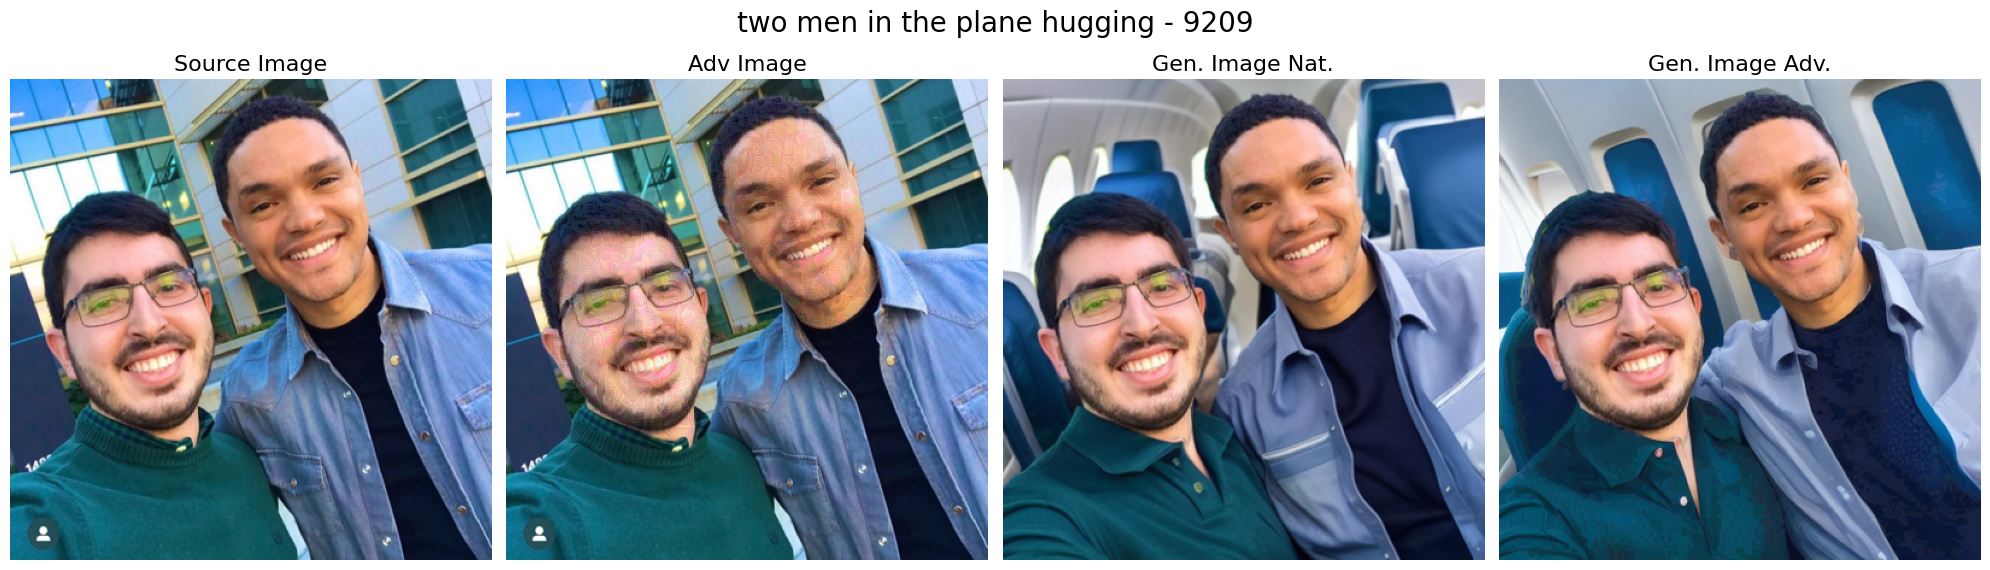

<Figure size 640x480 with 0 Axes>

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,6))

ax[0].imshow(init_image)
ax[1].imshow(adv_image)
ax[2].imshow(image_nat)
ax[3].imshow(image_adv)

ax[0].set_title('Source Image', fontsize=16)
ax[1].set_title('Adv Image', fontsize=16)
ax[2].set_title('Gen. Image Nat.', fontsize=16)
ax[3].set_title('Gen. Image Adv.', fontsize=16)

for i in range(4):
    ax[i].grid(False)
    ax[i].axis('off')
    
fig.suptitle(f"{prompt} - {SEED}", fontsize=20)
fig.tight_layout()
plt.show()
plt.savefig('photoguard_larger.png')

#### Notice how now the generated image from the adversarial example is completely unrealistic! Much stronger result than the simple attack of `demo_simple_attack_inpainting.ipynb`